# Análisis y predicción de flujos de movilidad vacacional en España Peninsula-Islas

## 0. Installs and Imports

In [25]:
# Installs
#%pip install -q -U matplotlib numpy pandas scikit-learn seaborn
#%pip install xgboost

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load Data

In [27]:
path_2022 = "../data/movilidad_provincias_2022.csv"
path_2023 = "../data/movilidad_provincias_2023.csv"
path_2024 = "../data/movilidad_provincias_2024.csv"

original_data_2022 = pd.read_csv(path_2022, sep=",")
original_data_2023 = pd.read_csv(path_2023, sep=",")
original_data_2024 = pd.read_csv(path_2024, sep=",")

df_2022 = original_data_2022.copy()
df_2023 = original_data_2023.copy()
df_2024 = original_data_2024.copy()

df = pd.concat([df_2022, df_2023, df_2024])

In [28]:
""" df_2022.info()
df_2022.head() """

' df_2022.info()\ndf_2022.head() '

## 2. Data Preparation

### 2.1 Dataset Exploratory Data Analysis (EDA)

In [29]:
# TODO: EDA (passar aqui del notebook del eda)

### 2.2 Data Wrangling
All this process is known as **Data Wrangling**. In particular, the whole data wrangling process implies:
- Define and apply an strategy for nulls and coding for categorical variables
- Analyze the variables distribution and correlation between them
- Remove outliers
- etc....

In [30]:
# Data cleaning

In [31]:
# DATA FILTERING
# Keep only the rows with destination province = ['Balears, Illes', 'Palmas, Las', 'Santa Cruz de Tenerife']
insular_provinces = ['Balears, Illes', 'Palmas, Las', 'Santa Cruz de Tenerife']
df = df[df['provincia_destino_name'].isin(insular_provinces)]
df

,viajeros,viajes,provincia_origen,provincia_origen_name,provincia_destino,provincia_destino_name,day
3,15,15,2,Albacete,7,"Balears, Illes",2022-09-01
25,118,123,2,Albacete,35,"Palmas, Las",2022-09-01
26,88,92,2,Albacete,38,Santa Cruz de Tenerife,2022-09-01
39,3026,3073,3,Alicante,7,"Balears, Illes",2022-09-01
64,110,143,3,Alicante,35,"Palmas, Las",2022-09-01
...,...,...,...,...,...,...,...
486703,117,119,47,Valladolid,35,"Palmas, Las",2024-09-30
486749,510,517,50,Zaragoza,7,"Balears, Illes",2024-09-30
486774,110,116,50,Zaragoza,35,"Palmas, Las",2024-09-30
486805,29,36,5,Ávila,35,"Palmas, Las",2024-09-30


## 3. Feature extraction

In [32]:
features_df = df.copy()

# Add two new columns, day_of_week and month
features_df['date'] = pd.to_datetime(features_df['day'])
features_df['day_of_week'] = features_df['date'].dt.day_name()
features_df['month'] = features_df['date'].dt.month
features_df['year'] = features_df['date'].dt.year
features_df.drop(columns=['day'], inplace=True)

features_df

,viajeros,viajes,provincia_origen,provincia_origen_name,provincia_destino,provincia_destino_name,date,day_of_week,month,year
3,15,15,2,Albacete,7,"Balears, Illes",2022-09-01,Thursday,9,2022
25,118,123,2,Albacete,35,"Palmas, Las",2022-09-01,Thursday,9,2022
26,88,92,2,Albacete,38,Santa Cruz de Tenerife,2022-09-01,Thursday,9,2022
39,3026,3073,3,Alicante,7,"Balears, Illes",2022-09-01,Thursday,9,2022
64,110,143,3,Alicante,35,"Palmas, Las",2022-09-01,Thursday,9,2022
...,...,...,...,...,...,...,...,...,...,...
486703,117,119,47,Valladolid,35,"Palmas, Las",2024-09-30,Monday,9,2024
486749,510,517,50,Zaragoza,7,"Balears, Illes",2024-09-30,Monday,9,2024
486774,110,116,50,Zaragoza,35,"Palmas, Las",2024-09-30,Monday,9,2024
486805,29,36,5,Ávila,35,"Palmas, Las",2024-09-30,Monday,9,2024


In [33]:
# Sum all the trips to the same destination province
total_llegadas_islas = features_df.groupby(['date', 'provincia_destino_name', 'day_of_week', 'month', 'year'])['viajes'].sum().reset_index()
total_llegadas_islas

,date,provincia_destino_name,day_of_week,month,year,viajes
0,2022-09-01,"Balears, Illes",Thursday,9,2022,27489
1,2022-09-01,"Palmas, Las",Thursday,9,2022,17094
2,2022-09-01,Santa Cruz de Tenerife,Thursday,9,2022,14233
3,2022-09-02,"Balears, Illes",Friday,9,2022,29444
4,2022-09-02,"Palmas, Las",Friday,9,2022,16292
...,...,...,...,...,...,...
2275,2024-09-29,"Palmas, Las",Sunday,9,2024,18728
2276,2024-09-29,Santa Cruz de Tenerife,Sunday,9,2024,17824
2277,2024-09-30,"Balears, Illes",Monday,9,2024,26655
2278,2024-09-30,"Palmas, Las",Monday,9,2024,19614


In [34]:
# Export to csv for the web app
total_llegadas_islas.to_csv('web/model_data.csv', index=False)

## 4. Model

In [35]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df1 = total_llegadas_islas.copy()
df1.drop(columns=['date'], inplace=True)
df1.drop(columns=['year'], inplace=True)

In [36]:
# Label encoding
le_day_of_week = LabelEncoder()
df1['day_of_week'] = le_day_of_week.fit_transform(df1['day_of_week'])
le_provincia_destino_name = LabelEncoder()
df1['provincia_destino_name'] = le_provincia_destino_name.fit_transform(df1['provincia_destino_name'])

# Correlation matrix
""" plt.figure(figsize=(12, 10))
sns.heatmap(df1.corr(), annot=True, cmap='coolwarm')
plt.show() """

" plt.figure(figsize=(12, 10))\nsns.heatmap(df1.corr(), annot=True, cmap='coolwarm')\nplt.show() "

In [37]:
features = df1.drop(columns=['viajes'])
target = df1['viajes']

X = features
y = target

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(1710, 570, 1710, 570)

### 4.1 Model Selection

In [38]:
# TODO: Train with best model
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [39]:
# XGBOOST
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [40]:
# RANDOM FOREST REGRESSOR
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)

In [41]:
# GRADIENT BOOSTING REGRESSOR
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

In [42]:
# LIGHTGBM
lgbmr = LGBMRegressor()
lgbmr.fit(X_train, y_train)
y_pred_lgbmr = lgbmr.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23
[LightGBM] [Info] Number of data points in the train set: 1710, number of used features: 3
[LightGBM] [Info] Start training from score 19183.076023


In [65]:
# Predicción de datos fake
isla = 'Balears, Illes'
dia = 'Wednesday'
mes = 7

fake_data = pd.DataFrame({'provincia_destino_name': [isla], 'day_of_week': [dia], 'month': [mes]})

fake_data['day_of_week'] = le_day_of_week.transform(fake_data['day_of_week'])
fake_data['provincia_destino_name'] = le_provincia_destino_name.transform(fake_data['provincia_destino_name'])

#fake_data

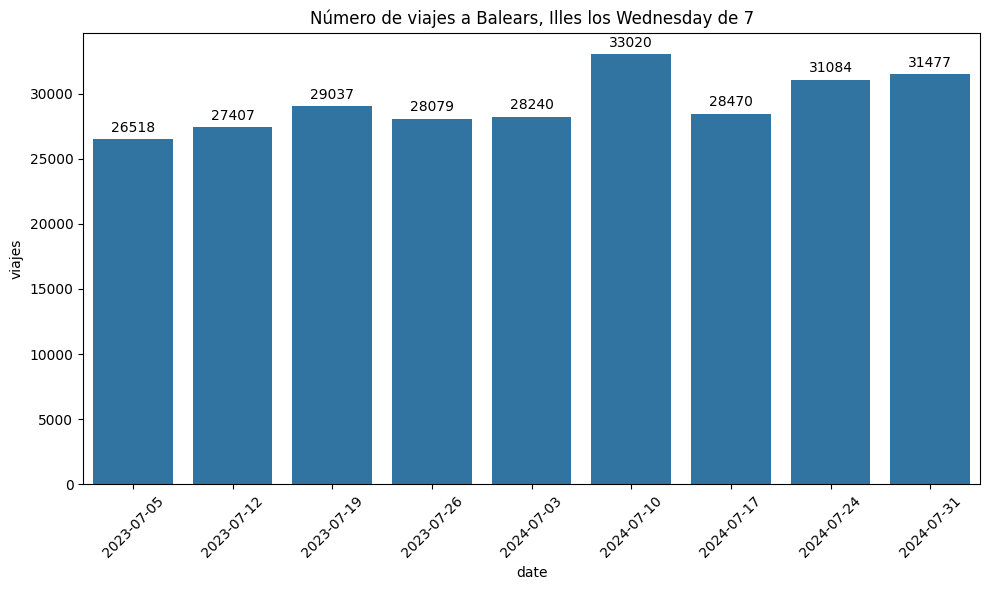

Media de viajes a Balears, Illes los Wednesday de 7: 29259.11111111111
--------------------
XGBoost: [29723.312]
Random Forest Regressor: [29696.60637074]
Gradient Boosting Regressor: [29196.25139405]
LightGBM: [29400.69503685]


In [66]:
u = total_llegadas_islas.copy()

# --- Visualización datos reales ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=u[(u["day_of_week"] == dia) & (u["month"] == mes) & (u["provincia_destino_name"] == isla)], x="date", y="viajes")

for i in ax.containers:
    ax.bar_label(i, padding=3)

plt.title(f"Número de viajes a {isla} los {dia} de {mes}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Media de viajes
media_viajes = u[(u["day_of_week"] == dia) & (u["month"] == mes) & (u["provincia_destino_name"] == isla)]['viajes'].mean()
print(f"Media de viajes a {isla} los {dia} de {mes}: {media_viajes}")

# --- Predicción de datos fake ---
y_pred_xgb_fake = xgb.predict(fake_data)
y_pred_rfr_fake = rfr.predict(fake_data)
y_pred_gbr_fake = gbr.predict(fake_data)
y_pred_lgbmr_fake = lgbmr.predict(fake_data)

print("--------------------")
print(f"XGBoost: {y_pred_xgb_fake}")
print(f"Random Forest Regressor: {y_pred_rfr_fake}")
print(f"Gradient Boosting Regressor: {y_pred_gbr_fake}")
print(f"LightGBM: {y_pred_lgbmr_fake}")

### 4.2 Tuning

In [ ]:
# TODO: Tuning (esta a sota de les conclusions)

## 5. Evaluation and Conclusions

In [52]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Evaluation metrics
mse_rf = mean_squared_error(y_test, y_pred_rfr)
mae_rf = mean_absolute_error(y_test, y_pred_rfr)
r2_rf = r2_score(y_test, y_pred_rfr)

mse_gbr = mean_squared_error(y_test, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

mse_lgbmr = mean_squared_error(y_test, y_pred_lgbmr)
mae_lgbmr = mean_absolute_error(y_test, y_pred_lgbmr)
r2_lgbmr = r2_score(y_test, y_pred_lgbmr)

print("----------------------")
print(f"Random Forest Regressor: MSE = {mse_rf}, MAE = {mae_rf}, R2 = {r2_rf}")
print(f"Gradient Boosting Regressor: MSE = {mse_gbr}, MAE = {mae_gbr}, R2 = {r2_gbr}")
print(f"XGBoost: MSE = {mse_xgb}, MAE = {mae_xgb}, R2 = {r2_xgb}")
print(f"LightGBM: MSE = {mse_lgbmr}, MAE = {mae_lgbmr}, R2 = {r2_lgbmr}")
print("----------------------")

----------------------
Random Forest Regressor: MSE = 9932929.82754554, MAE = 2404.309408387428, R2 = 0.6526152562518389
Gradient Boosting Regressor: MSE = 8940214.312840499, MAE = 2295.192394802984, R2 = 0.6873335348139507
XGBoost: MSE = 9967815.838300651, MAE = 2405.72186814693, R2 = 0.6513951864318597
LightGBM: MSE = 9293055.553357985, MAE = 2337.0868818732797, R2 = 0.674993604295058
----------------------


In [92]:
# Tuning all models
from sklearn.model_selection import GridSearchCV

def tuning_and_evaluating_models(X_train, y_train, X_test, y_test, models_with_params):
    results = {}

    for model, params in models_with_params.items():
        print(f"\n----------------------\nOptimizando {model.__class__.__name__} con GridSearchCV\n")

        # Configurar GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)

        # Mejor modelo
        best_model = grid_search.best_estimator_
        print(f"Mejores hiperparámetros para {model.__class__.__name__}: {grid_search.best_params_}")

        # Predicciones y métricas
        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Guardar resultados
        results[model.__class__.__name__] = {
            'Best Params': grid_search.best_params_,
            'MSE': mse,
            'MAE': mae,
            'R2': r2
        }

        # Mostrar resultados
        print(f"\nResultados de {model.__class__.__name__}:")
        print(f"MSE = {mse:.4f}, MAE = {mae:.4f}, R2 = {r2:.4f}")

    print("\n----------------------\nEvaluación completa\n")
    return results

In [ ]:
# TODO: Still tune the parameters
models_with_params = {
    RandomForestRegressor(): {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    GradientBoostingRegressor(): {
        'learning_rate': [0.01, 0.1, 1],
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 10]
    },
    XGBRegressor(): {
        'learning_rate': [0.01, 0.1, 1],
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 10]
    },
    LGBMRegressor(): {
        'learning_rate': [0.01, 0.1, 1],
        'n_estimators': [100, 200, 300],
        'num_leaves': [15, 30, 50]
    }
}

results = tuning_and_evaluating_models(X_train, y_train, X_test, y_test, models_with_params)



----------------------
Optimizando RandomForestRegressor con GridSearchCV

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores hiperparámetros para RandomForestRegressor: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}

Resultados de RandomForestRegressor:
MSE = 9594590.3671, MAE = 2376.9898, R2 = 0.6644

----------------------
Optimizando GradientBoostingRegressor con GridSearchCV

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores hiperparámetros para GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Resultados de GradientBoostingRegressor:
MSE = 8940214.3128, MAE = 2295.1924, R2 = 0.6873

----------------------
Optimizando XGBRegressor con GridSearchCV

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores hiperparámetros para XGBRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Resultados de XGBRegressor:
MSE = 8854584.6757, MAE = 2285.6889, R2 = 0.6903


In [47]:
# EXPLAINABILITY OF THE MODEL (ELI5, LIME, SHAP) ...
""" explainer = TreeExplainer(gbr)
shap_values = explainer.shap_values(X_test) """

""" shap.force_plot(base_value, shap_values[0]) #Local explanation
shap.plots.waterfall(shap_values[i]) #Local explanation
shap.plots.bar(shap_values[i]) #Local explanation
shap.summary_plot(shap_values) #Global features importance
shap.plots.bar(shap_values.abs.mean(0), max_display=20) #Global features importance
shap.plots.scatter(shap_values[:], feature1, color=shap_value[j]) """

' shap.force_plot(base_value, shap_values[0]) #Local explanation\nshap.plots.waterfall(shap_values[i]) #Local explanation\nshap.plots.bar(shap_values[i]) #Local explanation\nshap.summary_plot(shap_values) #Global features importance\nshap.plots.bar(shap_values.abs.mean(0), max_display=20) #Global features importance\nshap.plots.scatter(shap_values[:], feature1, color=shap_value[j]) '